In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


In [42]:
%load_ext autoreload
%autoreload
from src.modules.data_preprocessing import load_data
from dython.nominal import correlation_ratio
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
import missingno as msno
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neural_network import MLPClassifier
from src.modules.evaluation.imputation_quality import rmse, ws_cols
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def evaluation_clf(X_train, X_test, y_train, y_test, clf):
    if clf == 'mlp':
        clf = MLPClassifier(
            hidden_layer_sizes=(32), max_iter=1000, alpha=0.0001,
            solver='adam', verbose=0, random_state=21, tol=0.001
        )
    elif clf == 'rf':
        clf = RandomForestClassifier(n_estimators=500, random_state=0)
    elif clf == 'lr':
        clf = LogisticRegression(C=10,random_state=0)
    else:
        raise ValueError('clf must be mlp')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu = accuracy_score(y_test, y_pred)
    print(accu)

    return clf


# Adult

In [39]:
data, data_config = load_data('adult_balanced_pca')
for col in data.columns:
    print(correlation_ratio(data[data_config['target']], data[col]))

(45222, 41)
0.2638826434851498
0.26070862969680564
0.32391046027447173
0.12034929823233424
0.31458506107226614
0.3835488242149019
0.001839720624974581
0.0412184871471484
0.001335314638695972
0.014783165205196694
0.007474422032487724
0.04820407259084136
0.08676271062297243
0.046103084401949816
0.03330939710136692
0.035965066360560204
0.09596663173957139
0.011039689442626054
0.02737862026020589
0.014566867567098032
1.0


In [40]:
data_sampled = data.sample(frac=0.05, random_state=42)
print(data_sampled.shape)
data_sampled = data_sampled.values
X_train, X_test, y_train, y_test = train_test_split(
    data_sampled[:, :-1], data_sampled[:, -1], test_size=0.2, stratify=data_sampled[:,-1], random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#evaluation_clf(X_train, X_test, y_train, y_test, 'mlp')
evaluation_clf(X_train, X_test, y_train, y_test, 'rf')
evaluation_clf(X_train, X_test, y_train, y_test, 'lr')

(1121, 21)
(896, 20) (225, 20) (896,) (225,)
0.7955555555555556
0.8133333333333334


LogisticRegression(C=10, random_state=0)

(896, 21)


<Axes: >

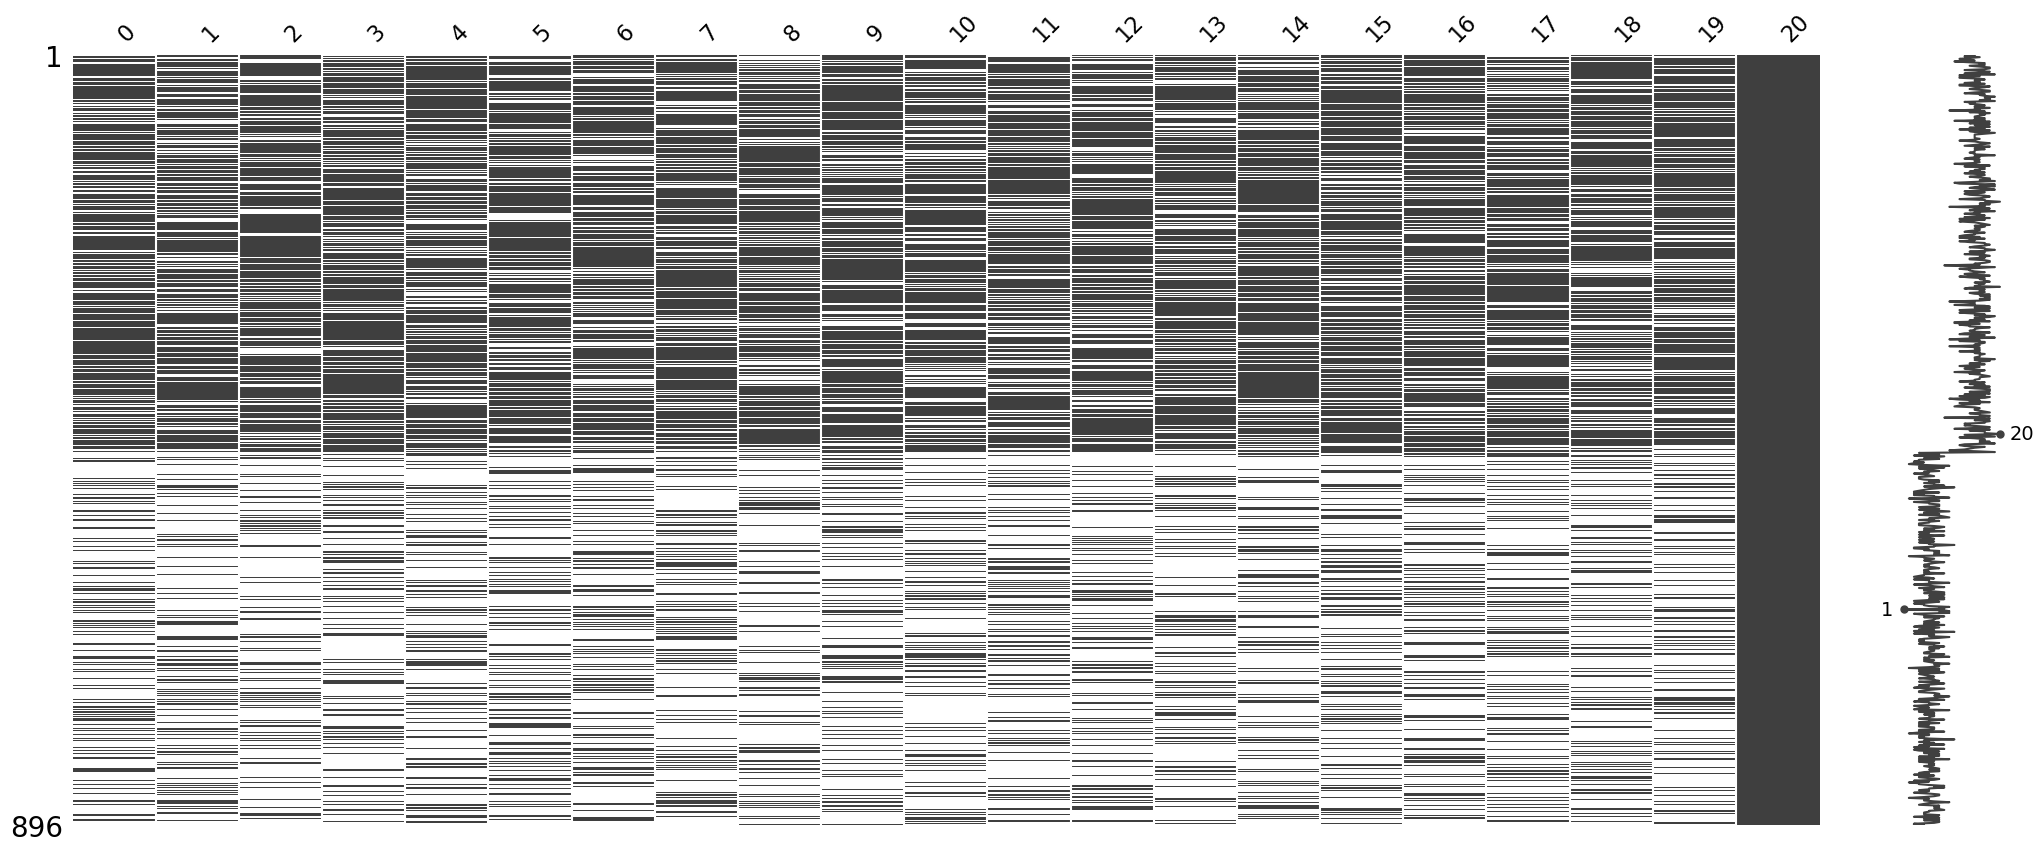

In [41]:
cols = list(range(X_train.shape[1]))
X_train_ms = simulate_nan_new(X_train, y_train, 
                           cols = cols, mechanism='mary_sigmoid_right', missing_ratio=0.5, seed=42)
data_ms = np.concatenate([X_train_ms, y_train.reshape(-1,1)], axis=1)
print(data_ms.shape)
df = pd.DataFrame(data_ms)
mask = np.isnan(X_train_ms)
msno.matrix(df.sort_values(by=df.columns[-1]))

## Mean Imputation

In [43]:
# Mean imputation
# single imputation ICE not uisng Y
base_estimator = BayesianRidge()
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), max_iter = 0,
    imputation_order='ascending', sample_posterior=False, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms], axis=1))
print(rmse(X_train, X_imp, mask))
evaluation_clf(X_imp, X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp, X_test, y_train, y_test, 'lr')

0.16772092079437415
0.56
0.7733333333333333


LogisticRegression(C=10, random_state=0)

## MICE Linear Imputation

In [44]:
# single imputation ICE not uisng Y
base_estimator = BayesianRidge()
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=False, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms], axis=1))
print(rmse(X_train, X_imp, mask))
evaluation_clf(X_imp, X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp, X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (896, 20)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.05
[IterativeImputer] Change: 0.6496835719216723, scaled tolerance: 0.0009999999967457377 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.10
[IterativeImputer] Change: 0.8279283827488133, scaled tolerance: 0.0009999999967457377 
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.14
[IterativeImputer] Change: 0.3078677340498498, scaled tolerance: 0.0009999999967457377 
[IterativeImputer] Ending imputation round 4/10, elapsed time 0.18
[IterativeImputer] Change: 0.19445799673566005, scaled tolerance: 0.0009999999967457377 
[IterativeImputer] Ending imputation round 5/10, elapsed time 0.21
[IterativeImputer] Change: 0.1720951827904595, scaled tolerance: 0.0009999999967457377 
[IterativeImputer] Ending imputation round 6/10, elapsed time 0.26
[IterativeImputer] Change: 0.1628450354021156, scaled tolerance: 0.0009999999967457377 
[IterativeI

d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.18372100807373146
0.6177777777777778
0.7422222222222222


d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, random_state=0)

In [45]:
# single imputation ICE uisng Y
base_estimator = BayesianRidge()
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=False, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms, y_train.reshape(-1,1)], axis=1))
print(rmse(X_train, X_imp[:, :-1], mask))
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (896, 21)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.05
[IterativeImputer] Change: 0.7979594984595474, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.11
[IterativeImputer] Change: 0.6730516751254715, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.17
[IterativeImputer] Change: 0.2891885693172529, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 4/10, elapsed time 0.22
[IterativeImputer] Change: 0.17994998409891544, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 5/10, elapsed time 0.27
[IterativeImputer] Change: 0.15527965540404598, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 6/10, elapsed time 0.31
[IterativeImputer] Change: 0.14650654797377533, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 7/10, elapsed time 0.35
[IterativeImputer] Change: 0.178019179

d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.6577777777777778
0.7066666666666667


LogisticRegression(C=10, random_state=0)

In [46]:
base_estimator = BayesianRidge()
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=True, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms], axis=1))
print(rmse(X_train, X_imp, mask))
evaluation_clf(X_imp, X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp, X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (896, 20)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.08
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.16
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.22
[IterativeImputer] Ending imputation round 4/10, elapsed time 0.29
[IterativeImputer] Ending imputation round 5/10, elapsed time 0.36
[IterativeImputer] Ending imputation round 6/10, elapsed time 0.42
[IterativeImputer] Ending imputation round 7/10, elapsed time 0.49
[IterativeImputer] Ending imputation round 8/10, elapsed time 0.56
[IterativeImputer] Ending imputation round 9/10, elapsed time 0.62
[IterativeImputer] Ending imputation round 10/10, elapsed time 0.69
0.23005646717099584
0.6311111111111111
0.7555555555555555


LogisticRegression(C=10, random_state=0)

In [48]:
base_estimator = BayesianRidge()
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=True, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms, y_train.reshape(-1,1)], axis=1))
print(rmse(X_train, X_imp[:, :-1], mask))
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (896, 21)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.09
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.18
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.26
[IterativeImputer] Ending imputation round 4/10, elapsed time 0.34
[IterativeImputer] Ending imputation round 5/10, elapsed time 0.42
[IterativeImputer] Ending imputation round 6/10, elapsed time 0.49
[IterativeImputer] Ending imputation round 7/10, elapsed time 0.57
[IterativeImputer] Ending imputation round 8/10, elapsed time 0.63
[IterativeImputer] Ending imputation round 9/10, elapsed time 0.70
[IterativeImputer] Ending imputation round 10/10, elapsed time 0.78
0.22599291478520026
0.6355555555555555
0.7822222222222223


LogisticRegression(C=10, random_state=0)

## Missforest Imputation

In [49]:
# single imputation Missforest not uisng Y
base_estimator = RandomForestRegressor(n_estimators=200, random_state=0)
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=False, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms], axis=1))
print(rmse(X_train, X_imp, mask))
evaluation_clf(X_imp, X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp, X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (896, 20)
[IterativeImputer] Ending imputation round 1/10, elapsed time 28.17
[IterativeImputer] Change: 2.1538425817224374, scaled tolerance: 0.0009999999967457377 
[IterativeImputer] Ending imputation round 2/10, elapsed time 58.26
[IterativeImputer] Change: 1.9820990020660316, scaled tolerance: 0.0009999999967457377 
[IterativeImputer] Ending imputation round 3/10, elapsed time 87.84
[IterativeImputer] Change: 1.0095814124135722, scaled tolerance: 0.0009999999967457377 
[IterativeImputer] Ending imputation round 4/10, elapsed time 117.76
[IterativeImputer] Change: 1.3382163097486823, scaled tolerance: 0.0009999999967457377 
[IterativeImputer] Ending imputation round 5/10, elapsed time 145.65
[IterativeImputer] Change: 1.2676640183472625, scaled tolerance: 0.0009999999967457377 
[IterativeImputer] Ending imputation round 6/10, elapsed time 173.53
[IterativeImputer] Change: 1.2673864519168072, scaled tolerance: 0.0009999999967457377 
[It

d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.19477760032708444
0.6977777777777778
0.7511111111111111


LogisticRegression(C=10, random_state=0)

In [50]:
# single imputation Missforest uisng Y
base_estimator = RandomForestRegressor(n_estimators=200, random_state=0)
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=False, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms, y_train.reshape(-1,1)], axis=1))
print(rmse(X_train, X_imp[:, :-1], mask))
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (896, 21)
[IterativeImputer] Ending imputation round 1/10, elapsed time 27.69
[IterativeImputer] Change: 2.0015121285877635, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 2/10, elapsed time 58.25
[IterativeImputer] Change: 1.8102430213272824, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 3/10, elapsed time 88.96
[IterativeImputer] Change: 1.0301745218253342, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 4/10, elapsed time 119.69
[IterativeImputer] Change: 1.1662695602810773, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 5/10, elapsed time 150.63
[IterativeImputer] Change: 0.9718245219629678, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 6/10, elapsed time 181.20
[IterativeImputer] Change: 1.3869570702808829, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 7/10, elapsed time 211.74
[IterativeImputer] Change: 0.9

d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.18844237866391875
0.7111111111111111
0.7555555555555555


LogisticRegression(C=10, random_state=0)

## MICE Non-linear GP

In [51]:
# single imputation using Y and without sampling
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
base_estimator = gaussian_process
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), verbose=2,
    imputation_order='ascending', sample_posterior=True, n_nearest_features=None,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms, y_train.reshape(-1,1)], axis=1))
print(rmse(X_train, X_imp[:, :-1], mask))
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (896, 21)
[IterativeImputer] Ending imputation round 1/10, elapsed time 288.75
[IterativeImputer] Ending imputation round 2/10, elapsed time 583.40
[IterativeImputer] Ending imputation round 3/10, elapsed time 934.97
[IterativeImputer] Ending imputation round 4/10, elapsed time 1263.34


d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[IterativeImputer] Ending imputation round 5/10, elapsed time 1591.90


d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[IterativeImputer] Ending imputation round 6/10, elapsed time 1903.64
[IterativeImputer] Ending imputation round 7/10, elapsed time 2242.75
[IterativeImputer] Ending imputation round 8/10, elapsed time 2564.12
[IterativeImputer] Ending imputation round 9/10, elapsed time 2888.72


d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[IterativeImputer] Ending imputation round 10/10, elapsed time 3209.26
0.2721240470423376
0.6222222222222222
0.6622222222222223


LogisticRegression(C=10, random_state=0)

In [36]:
# single imputation using Y and sampling
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), verbose=2,
    imputation_order='ascending', sample_posterior=True, n_nearest_features=None,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms, y_train.reshape(-1,1)], axis=1))
print(rmse(X_train, X_imp[:, :-1], mask))
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (1134, 5)


TypeError: ForestRegressor.predict() got an unexpected keyword argument 'return_std'

In [166]:
def ensembling(clfs, X_test, y_test):
    n_samples = len(X_test)
    n_classes = len(np.unique(y_test))
    probas = np.zeros((n_samples, n_classes))
    for clf in clfs:
        proba_estimator = clf.predict_proba(X_test)
        probas += proba_estimator
    
    final_pred = np.argmax(probas, axis=1)
    return final_pred

In [180]:
# Multiple Imputation

# boostrapping
B = 100
num_resamples = 0.8
num_data_points = int(len(X_train_ms)*num_resamples)
seed = 42

clfs = []
Xs, ys = [], []
for batch in range(B):
    print(batch)
    seed = seed + batch*102903
    imputer = IterativeImputer(
        random_state=seed, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
        imputation_order='ascending', sample_posterior=True, n_nearest_features=None
    )
    # resampling
    X_train_ms_rs, y_train_rs = resample(
        X_train_ms, y_train, n_samples=num_data_points, replace = True, random_state=seed, stratify=y_train
    )
    mask_rs = np.isnan(X_train_ms_rs)
    print(X_train_ms_rs.shape, y_train_rs.shape)

    # imputation
    X_train_ms_imp = imputer.fit_transform(X_train_ms_rs)
    Xs.append(X_train_ms_imp)
    ys.append(y_train_rs)
    # train
    # clf = evaluation_clf(X_train_ms_imp, X_test, y_train_rs, y_test, 'mlp')
    # clfs.append(clf)

# final_pred = ensembling(clfs, X_test, y_test)
# print(accuracy_score(y_test, final_pred))

0
(4714, 20) (4714,)
1
(4714, 20) (4714,)
2
(4714, 20) (4714,)
3
(4714, 20) (4714,)
4
(4714, 20) (4714,)
5
(4714, 20) (4714,)
6
(4714, 20) (4714,)
7
(4714, 20) (4714,)
8
(4714, 20) (4714,)
9
(4714, 20) (4714,)
10
(4714, 20) (4714,)
11
(4714, 20) (4714,)
12
(4714, 20) (4714,)
13
(4714, 20) (4714,)
14
(4714, 20) (4714,)
15
(4714, 20) (4714,)
16
(4714, 20) (4714,)
17
(4714, 20) (4714,)
18
(4714, 20) (4714,)
19
(4714, 20) (4714,)
20
(4714, 20) (4714,)
21
(4714, 20) (4714,)
22
(4714, 20) (4714,)
23
(4714, 20) (4714,)
24
(4714, 20) (4714,)
25
(4714, 20) (4714,)
26
(4714, 20) (4714,)
27
(4714, 20) (4714,)
28
(4714, 20) (4714,)
29
(4714, 20) (4714,)
30
(4714, 20) (4714,)
31
(4714, 20) (4714,)
32
(4714, 20) (4714,)
33
(4714, 20) (4714,)
34
(4714, 20) (4714,)
35
(4714, 20) (4714,)
36
(4714, 20) (4714,)
37
(4714, 20) (4714,)
38
(4714, 20) (4714,)
39
(4714, 20) (4714,)
40
(4714, 20) (4714,)
41
(4714, 20) (4714,)
42
(4714, 20) (4714,)
43
(4714, 20) (4714,)
44
(4714, 20) (4714,)
45
(4714, 20) (4714,

In [181]:
X_new= np.concatenate(Xs, axis=0)
y_new = np.concatenate(ys, axis=0)
evaluation_clf(X_new, X_test, y_new, y_test, 'lr')

KeyboardInterrupt: 

In [183]:
# ensembling
clfs = []
for i in range(B):
    clf = evaluation_clf(Xs[i], X_test, ys[i], y_test, 'rf')
    clfs.append(clf)

final_pred = ensembling(clfs, X_test, y_test)
print(accuracy_score(y_test, final_pred))
print(recall_score(y_test, final_pred))
print(precision_score(y_test, final_pred))

0.5617367706919946
0.5739484396200815
0.5664857530529173
0.5610583446404342
0.587516960651289
0.5780189959294437
0.5685210312075983
0.5658073270013568
0.5834464043419267
0.5617367706919946
0.573270013568521
0.5644504748982361
0.5590230664857531
0.578697421981004
0.5590230664857531
0.5739484396200815
0.5495251017639078
0.5434192672998643
0.5468113975576662
0.5508819538670285
0.5563093622795116
0.5671641791044776
0.5780189959294437
0.5630936227951153
0.573270013568521
0.5583446404341926
0.5502035278154681
0.5576662143826323
0.5563093622795116
0.55359565807327
0.5617367706919946
0.5800542740841248
0.5576662143826323
0.5474898236092266
0.5583446404341926
0.5549525101763908
0.5807327001356852
0.5522388059701493
0.5868385345997287
0.562415196743555
0.55359565807327
0.5474898236092266
0.5644504748982361
0.5603799185888738
0.5569877883310719
0.5583446404341926
0.5651289009497965
0.5746268656716418
0.5576662143826323
0.5841248303934871
0.5590230664857531
0.5488466757123474
0.5447761194029851
0.

In [184]:
final = []
for clf in clfs:
    ret = clf.predict(X_test)
    final.append(ret)

final = np.array(final).T
sum_ = np.sum(final, axis=1)
corrected0 = 0
corrected1 = 0
for i in range(sum_.shape[0]):
    print(sum_[i], y_test[i])
    if sum_[i] <= B/2 and y_test[i] == 0:
        corrected0 += 1
    elif sum_[i] > B/2 and y_test[i] == 1:
        corrected1 += 1

print(corrected0/len(y_test)*2)
print(corrected1/len(y_test)*2)

KeyboardInterrupt: 

In [172]:
y_test.sum()

746.0